# Part A: Newtonian Dynamics 

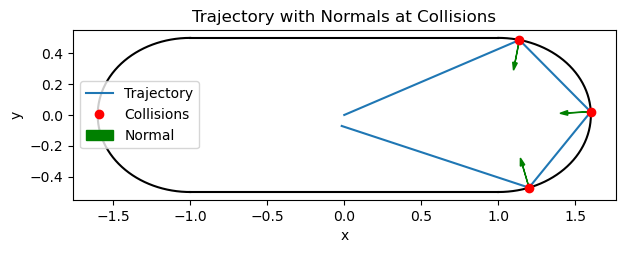

Collision 0: angle_in = 55.8087 deg, angle_out = 55.8087 deg, diff = 1.11e-16 rad
Collision 1: angle_in = 48.0280 deg, angle_out = 48.0280 deg, diff = 1.11e-16 rad
Collision 2: angle_in = 55.4503 deg, angle_out = 55.4503 deg, diff = 2.22e-16 rad
Plot saved as: r1.png


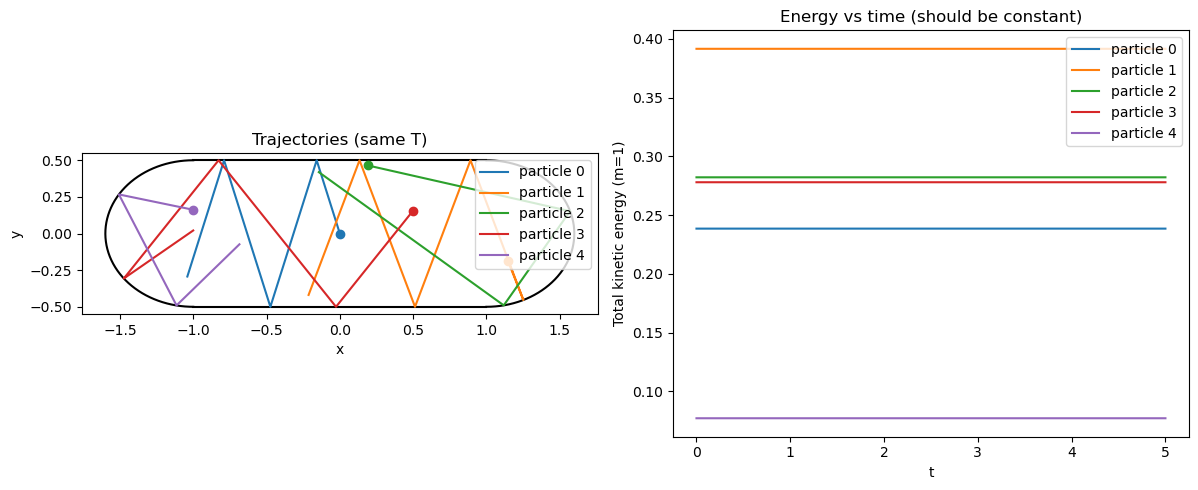

Plot saved as: r2.png


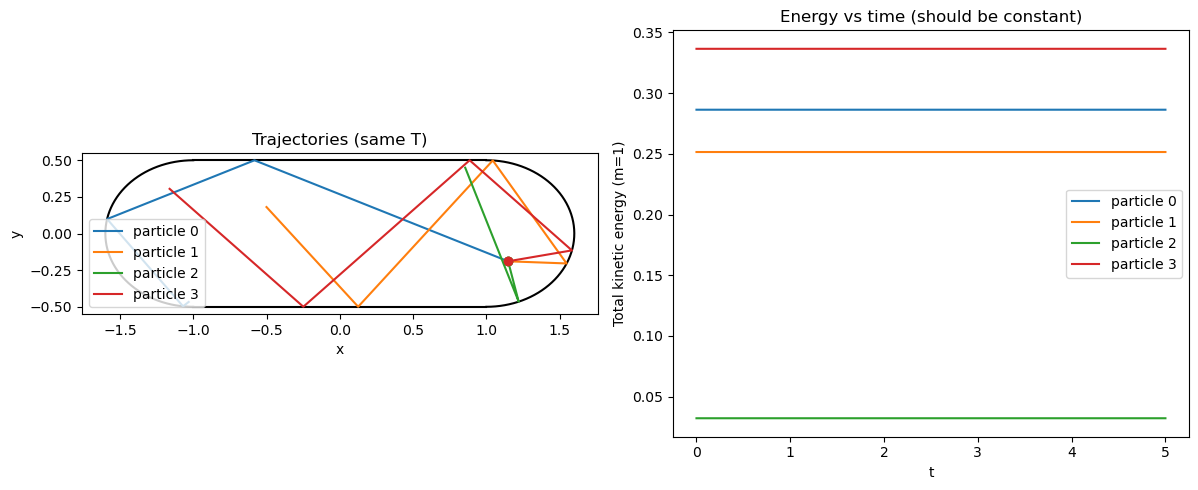

Plot saved as: r3.png


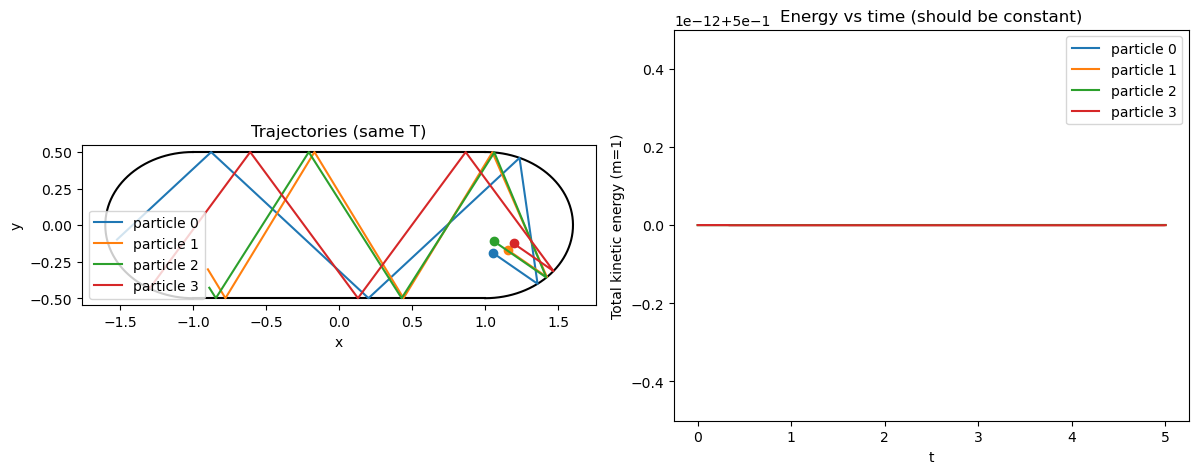

Plot saved as: r4.png


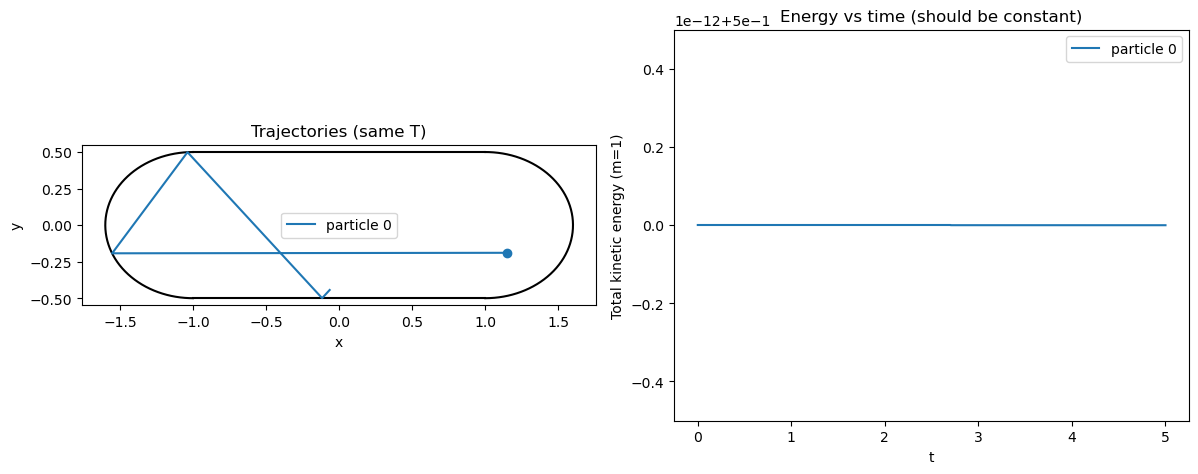

Plot saved as: r5.png


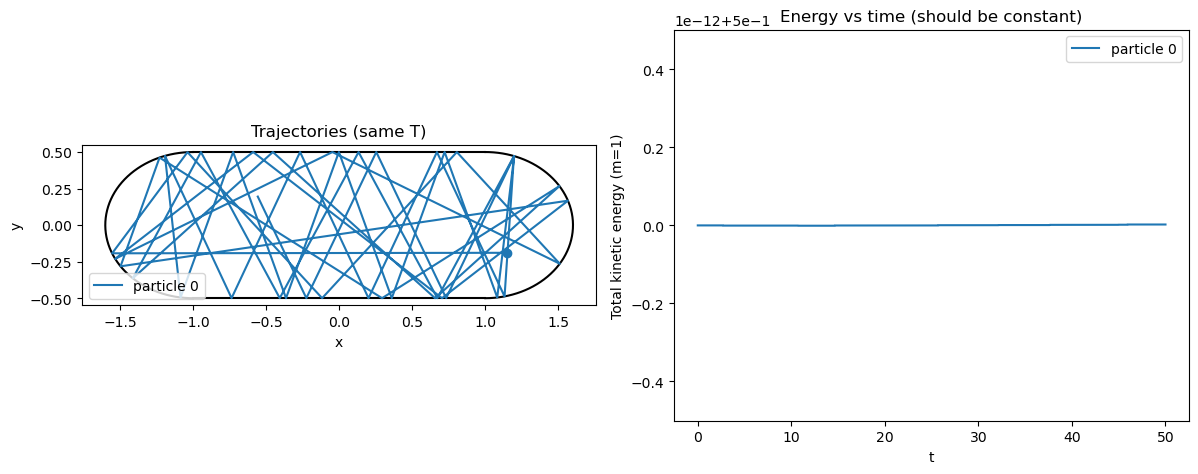

Plot saved as: r6.png


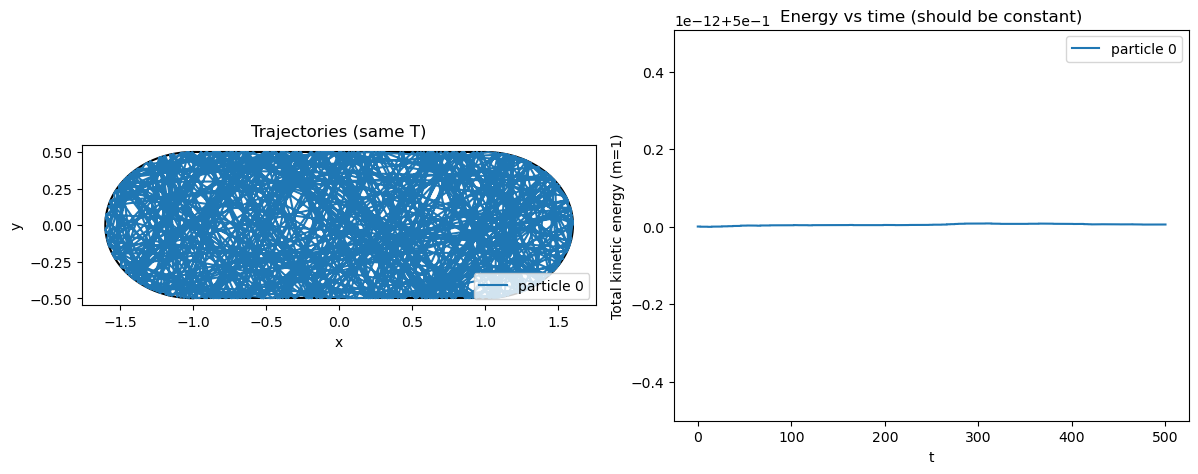

In [9]:
"""
Stadium (rectangle + elliptic caps) Newtonian dynamics with elastic reflection.

Provided functions:
 - is_inside_stadium(x,y,a,b,rx,ry)
 - sample_point_in_stadium(a,b,rx,ry)    # uniform inside (no rejection)
 - sample_point_on_boundary(a,b,rx,ry)   # uniform on boundary by arc-length
 - boundary_normal(x,y,a,b,rx,ry)        # inward unit normal at boundary point (geometric)
 - reflect_velocity(v, n)                # elastic reflection using inward normal n
 - integrate_trajectories(initial_conditions, a,b,rx,ry, dt, T)  # stepper with collision detection
 - utilities to plot trajectories and energies

Assumptions explicitly written in header comments above.
"""
import numpy as np
import matplotlib.pyplot as plt
from math import pi, sqrt, sin, cos
from typing import Tuple

# ---------------------------
# Geometry & analytic helpers
# ---------------------------

def is_inside_stadium(x: float, y: float, a: float, b: float, rx: float, ry: float) -> bool:
    """
    Test whether (x,y) is inside the stadium: rectangle |x|<=a,|y|<=b plus
    half-ellipses attached at x = +/- a.
    """
    if -a <= x <= a:
        return abs(y) <= b
    elif x > a:
        return ((x - a)**2) / (rx**2) + (y**2) / (ry**2) <= 1.0
    else:  # x < -a
        return ((x + a)**2) / (rx**2) + (y**2) / (ry**2) <= 1.0

def ellipse_half_area(rx: float, ry: float) -> float:
    """Area of a half-ellipse."""
    return 0.5 * pi * rx * ry

def stadium_area(a: float, b: float, rx: float, ry: float) -> float:
    """Total area: rectangle + two half-ellipses."""
    A_rect = 2*a * 2*b  # full rectangle
    A_caps = 2 * ellipse_half_area(rx, ry)
    return A_rect + A_caps

def approximate_ellipse_circumference(rx: float, ry: float) -> float:
    """Ramanujan approximation for ellipse circumference"""
    h = ((rx - ry)**2) / ((rx + ry)**2)
    C = pi * (rx + ry) * (1 + (3*h)/(10 + sqrt(4 - 3*h)))
    return C

def half_ellipse_arc_length(rx: float, ry: float) -> float:
    """Approximate half-ellipse arc length as half the full circumference (good approximation)."""
    return 0.5 * approximate_ellipse_circumference(rx, ry)

# ---------------------------
# Uniform sampling (no rejection)
# ---------------------------

def sample_point_in_stadium(a: float, b: float, rx: float, ry: float) -> Tuple[float,float]:
    """
    Uniform sampling inside stadium by area partition:
    - Sample whether point lies in rectangle or in left/right half-ellipse based on areas.
    - For rectangle: uniform in x in [-a,a], y in [-b,b].
    - For half-ellipse: sample radius r = sqrt(u) (u~U(0,1)) and angle phi restricted to the half.
        For right half (center at +a): phi in [-pi/2, pi/2] (cos phi >= 0).
        For left half (center at -a): phi in [pi/2, 3pi/2] (cos phi <= 0).
      Map elliptical coordinates: (x,y) = center + (rx * r * cos phi, ry * r * sin phi).
    """
    A_rect = 4*a*b
    A_caps_total = pi * rx * ry
    A_total = A_rect + A_caps_total
    r = np.random.rand() * A_total
    if r < A_rect:
        # rectangle
        x = np.random.uniform(-a, a)
        y = np.random.uniform(-b, b)
        return (x, y)
    else:
        # pick left or right cap with equal area (they're symmetric)
        if np.random.rand() < 0.5:
            # right cap centered at (+a,0), phi in [-pi/2, pi/2]
            phi = np.random.uniform(-pi/2, pi/2)
            u = np.random.rand()
            rad = sqrt(u)
            x = a + rx * rad * np.cos(phi)
            y =       ry * rad * np.sin(phi)
            return (x, y)
        else:
            # left cap centered at (-a,0), phi in [pi/2, 3pi/2]
            phi = np.random.uniform(pi/2, 3*pi/2)
            u = np.random.rand()
            rad = sqrt(u)
            x = -a + rx * rad * np.cos(phi)
            y =        ry * rad * np.sin(phi)
            return (x, y)

def sample_point_on_boundary(a: float, b: float, rx: float, ry: float) -> Tuple[float,float]:
    """
    Sample a point uniformly on the stadium boundary by arc-length partition.
    Boundary segments:
      - top flat: length 2a at y = +b
      - bottom flat: length 2a at y = -b
      - right half-ellipse arc: approximate half_ellipse_arc_length(rx,ry)
      - left half-ellipse arc: same
    (If you want vertical connectors, add them and adjust lengths accordingly.)
    """
    L_top = 2*a
    L_bottom = 2*a
    L_right = half_ellipse_arc_length(rx, ry)
    L_left = L_right
    L_total = L_top + L_bottom + L_right + L_left

    s = np.random.rand() * L_total
    if s < L_top:
        # top flat
        t = s / L_top  # in [0,1]
        x = -a + 2*a * t
        y = b
        return (x, y)
    s -= L_top
    if s < L_bottom:
        t = s / L_bottom
        x = a - 2*a * t  # go from +a to -a (order arbitrary)
        y = -b
        return (x, y)
    s -= L_bottom
    if s < L_right:
        # sample along param theta for right half-ellipse
        # we cannot invert arc-length analytically; approximate by sampling theta with density proportional to local ds/dtheta.
        # Simple practical approach: sample theta uniformly in [-pi/2,pi/2] and map to point (approx uniform w.r.t arc-length only approximately).
        # For exactness, one would precompute theta->arc-length table and invert. We'll implement a small invert using numeric bisection on arc-length.
        return _sample_halfellipse_point_by_arclength(a, 0.0, rx, ry, side='right', s_local=s, total_arc=L_right)
    s -= L_right
    # left
    return _sample_halfellipse_point_by_arclength(-a, 0.0, rx, ry, side='left', s_local=s, total_arc=L_left)

def _halfellipse_arclength_integrand(theta: float, rx: float, ry: float) -> float:
    # ds/dtheta = sqrt((dx/dtheta)^2 + (dy/dtheta)^2)
    # param: x = rx cos theta, y = ry sin theta
    dx = -rx * sin(theta)
    dy =  ry * cos(theta)
    return sqrt(dx*dx + dy*dy)

def _sample_halfellipse_point_by_arclength(cx: float, cy: float, rx: float, ry: float, side: str, s_local: float, total_arc: float) -> Tuple[float,float]:
    """
    Compute the angle theta such that arc-length from theta_min to theta equals s_local (bisection on theta).
    Right half uses theta in [-pi/2, pi/2] (cos>=0). Left uses [pi/2, 3pi/2].
    For speed we use numeric integration (adaptive Simpson or simple composite).
    """
    # choose theta bounds
    if side == 'right':
        th0, th1 = -pi/2, pi/2
        # reference paramization x = cx + rx cos theta, y = ry sin theta
    else:
        th0, th1 = pi/2, 3*pi/2

    # Precompute arc-length function via simple composite Simpson or trapezoid with moderate N
    N = 400  # moderate resolution for arc-length inversion
    thetas = np.linspace(th0, th1, N+1)
    integrand_vals = np.array([_halfellipse_arclength_integrand(t, rx, ry) for t in thetas])
    # cumulative trapezoid
    cum = np.concatenate(([0.0], np.cumsum((integrand_vals[:-1] + integrand_vals[1:]) * 0.5 * (thetas[1]-thetas[0]))))
    # now invert s_local to theta by linear interpolation
    if s_local <= 0:
        theta = th0
    elif s_local >= cum[-1]:
        theta = th1
    else:
        idx = np.searchsorted(cum, s_local) - 1
        idx = max(0, min(idx, N-1))
        t_frac = (s_local - cum[idx]) / (cum[idx+1] - cum[idx])
        theta = thetas[idx] + t_frac * (thetas[idx+1] - thetas[idx])
    x = cx + rx * np.cos(theta)
    y = cy + ry * np.sin(theta)
    return (x, y)

# ---------------------------
# Normals & reflections
# ---------------------------

def boundary_normal(x: float, y: float, a: float, b: float, rx: float, ry: float) -> np.ndarray:
    """
    Returns the inward unit normal at a boundary point (x,y).
    Assumes (x,y) lies on the boundary (or very close). We detect which piece it's on:
     - top/bottom flat: normal is (0,-1) at top, (0,1) at bottom (inward).
     - right/left half-ellipse: inward normal is - grad(F) / |grad(F)| where
           F(x,y) = ((x - cx)^2)/rx^2 + (y^2)/ry^2 - 1
       For right cap cx=+a; for left cx=-a.
     - if the point is ambiguous near junctions, we pick the piece by proximity.
    """
    eps = 1e-9
    # check top/bottom flats (approx)
    if abs(abs(y) - b) < 1e-8 and -a - 1e-8 <= x <= a + 1e-8:
        if y > 0:
            return np.array([0.0, -1.0])  # top -> inward points down
        else:
            return np.array([0.0, 1.0])   # bottom -> inward points up
    # check right ellipse
    val_right = ((x - a)**2)/(rx**2) + (y**2)/(ry**2)
    if abs(val_right - 1.0) < 1e-6 and x >= a - 1e-6:
        # grad F = (2(x-a)/rx^2, 2y/ry^2); outward = grad; inward = -grad
        gx = 2.0*(x - a)/(rx**2)
        gy = 2.0*y/(ry**2)
        nin = -np.array([gx, gy])
        norm = np.linalg.norm(nin)
        if norm < eps:
            return np.array([ -1.0, 0.0 ])  # fallback (point at center?), inward pointing left
        return nin / norm
    # check left ellipse
    val_left = ((x + a)**2)/(rx**2) + (y**2)/(ry**2)
    if abs(val_left - 1.0) < 1e-6 and x <= -a + 1e-6:
        gx = 2.0*(x + a)/(rx**2)
        gy = 2.0*y/(ry**2)
        nin = -np.array([gx, gy])
        norm = np.linalg.norm(nin)
        if norm < eps:
            return np.array([ 1.0, 0.0 ])
        return nin / norm
    # fallback: determine nearest piece and return its inward normal
    # check distance to top/bottom flats
    dtop = abs(y - b)
    dbot = abs(y + b)
    dright = abs(val_right - 1.0)
    dleft = abs(val_left - 1.0)
    mind = min(dtop, dbot, dright, dleft)
    if mind == dtop:
        return np.array([0.0, -1.0])
    if mind == dbot:
        return np.array([0.0, 1.0])
    if mind == dright:
        # compute right normal
        gx = 2.0*(x - a)/(rx**2)
        gy = 2.0*y/(ry**2)
        nin = -np.array([gx, gy])
        nrm = np.linalg.norm(nin)
        return nin / max(nrm, eps)
    # left
    gx = 2.0*(x + a)/(rx**2)
    gy = 2.0*y/(ry**2)
    nin = -np.array([gx, gy])
    nrm = np.linalg.norm(nin)
    return nin / max(nrm, eps)

def reflect_velocity(v: np.ndarray, n_inward: np.ndarray) -> np.ndarray:
    """
    Elastic reflection across boundary with inward normal n_inward (unit).
    v' = v - 2 (v . n_inward) n_inward
    """
    return v - 2.0 * np.dot(v, n_inward) * n_inward

# ---------------------------
# Time integration + collision detection
# ---------------------------

def find_collision_time_between(x: np.ndarray, v: np.ndarray, dt: float, a: float, b: float, rx: float, ry: float) -> Tuple[bool, float, np.ndarray]:
    """
    Determine if the straight-line trajectory x(t) = x + v*t (t in [0,dt]) leaves the stadium.
    If it does, find the first collision time t_c in [0,dt] such that x + v*t_c lies on the boundary.
    We use bisection on the scalar function f(t) = inside(x + v*t) (True/False) and find the crossing to boundary.
    Returns (collision_found, t_collision, collision_point).
    If no collision (stays inside for the whole dt), returns (False, None, None).
    Assumes starting point x is inside (or on) the stadium.
    """
    # quick check: if endpoint is inside, no collision
    x_end = x + v*dt
    if is_inside_stadium(x_end[0], x_end[1], a, b, rx, ry):
        return (False, None, None)

    # otherwise there is at least one crossing. bisection for first crossing:
    t_lo = 0.0
    t_hi = dt
    # We want the first time where point is on the boundary (i.e., inside -> outside). We'll binary search for boundary crossing.
    # Define predicate inside_at(t)
    def inside_at(t):
        pt = x + v*t
        return is_inside_stadium(pt[0], pt[1], a, b, rx, ry)

    # ensure inside at t_lo and outside at t_hi
    if not inside_at(t_lo):
        # starting outside - treat as collision at t=0
        return (True, 0.0, x.copy())
    if inside_at(t_hi):
        # numerical corner-case, no crossing
        return (False, None, None)

    # bisection to find t where inside switches to outside: want t* such that inside(t*) ~= True and inside(t*+eps) ~= False
    for _ in range(40):
        tm = 0.5*(t_lo + t_hi)
        if inside_at(tm):
            t_lo = tm
        else:
            t_hi = tm
    t_collision = 0.5*(t_lo + t_hi)
    collision_point = x + v * t_collision
    # optionally project the collision point onto boundary by snapping via normal gradient, but it's ok
    return (True, t_collision, collision_point)

def integrate_particle(x0: np.ndarray, v0: np.ndarray, a: float, b: float, rx: float, ry: float, dt: float, T: float) -> Tuple[np.ndarray,np.ndarray,np.ndarray]:
    """
    Integrate a single particle with initial position x0 and velocity v0 over time T with timestep dt.
    Handles elastic reflections by bisection to find collision time inside each dt, reflect, and continue with remaining timestep.
    Returns arrays: times, positions (N x 2), velocities (N x 2).
    """
    nsteps = int(np.ceil(T / dt))
    t = 0.0
    x = x0.copy()
    v = v0.copy()
    times = [0.0]
    positions = [x.copy()]
    velocities = [v.copy()]

    for step in range(nsteps):
        remaining_dt = dt
        # In each timestep we might have multiple collisions if the timestep is huge; loop until remaining_dt consumed
        subiter = 0
        while remaining_dt > 1e-12 and subiter < 10:
            subiter += 1
            collided, tcol, pcol = find_collision_time_between(x, v, remaining_dt, a, b, rx, ry)
            if not collided:
                # no collision in remaining_dt: advance
                x = x + v * remaining_dt
                t += remaining_dt
                remaining_dt = 0.0
                break
            else:
                # advance to collision time
                if tcol < 1e-14:
                    # collision at current location (grazing or numerical); try to push out slightly along normal
                    n = boundary_normal(x[0], x[1], a, b, rx, ry)
                    v = reflect_velocity(v, n)
                    # small move to leave boundary
                    x = x + v * (1e-8)
                    continue
                # move to collision point
                x = x + v * tcol
                t += tcol
                remaining_dt -= tcol
                # compute normal at collision
                n = boundary_normal(x[0], x[1], a, b, rx, ry)
                v = reflect_velocity(v, n)
                # After reflection continue for the remaining_dt (loop)
        times.append(t)
        positions.append(x.copy())
        velocities.append(v.copy())
    return np.array(times), np.array(positions), np.array(velocities)

def integrate_particle_with_normals(x0: np.ndarray, v0: np.ndarray, a: float, b: float, rx: float, ry: float, dt: float, T: float):
    """
    Like integrate_particle, but also records collision points, incident/reflected velocities, and normals.
    Returns: times, positions, velocities, collision_points, incident_vs, reflected_vs, normals
    """
    nsteps = int(np.ceil(T / dt))
    t = 0.0
    x = x0.copy()
    v = v0.copy()
    times = [0.0]
    positions = [x.copy()]
    velocities = [v.copy()]
    collision_points = []
    incident_vs = []
    reflected_vs = []
    normals = []

    for step in range(nsteps):
        remaining_dt = dt
        subiter = 0
        while remaining_dt > 1e-12 and subiter < 10:
            subiter += 1
            collided, tcol, pcol = find_collision_time_between(x, v, remaining_dt, a, b, rx, ry)
            if not collided:
                x = x + v * remaining_dt
                t += remaining_dt
                remaining_dt = 0.0
                break
            else:
                if tcol < 1e-14:
                    n = boundary_normal(x[0], x[1], a, b, rx, ry)
                    v_new = reflect_velocity(v, n)
                    # Record collision
                    collision_points.append(x.copy())
                    incident_vs.append(v.copy())
                    reflected_vs.append(v_new.copy())
                    normals.append(n.copy())
                    v = v_new
                    x = x + v * (1e-8)
                    continue
                # move to collision point
                x = x + v * tcol
                t += tcol
                remaining_dt -= tcol
                n = boundary_normal(x[0], x[1], a, b, rx, ry)
                v_new = reflect_velocity(v, n)
                # Record collision
                collision_points.append(x.copy())
                incident_vs.append(v.copy())
                reflected_vs.append(v_new.copy())
                normals.append(n.copy())
                v = v_new
        times.append(t)
        positions.append(x.copy())
        velocities.append(v.copy())
    return (np.array(times), np.array(positions), np.array(velocities),
            np.array(collision_points), np.array(incident_vs), np.array(reflected_vs), np.array(normals))

def integrate_trajectories(initial_conditions, a, b, rx, ry, dt, T):
    """
    initial_conditions: list of (x0 (2-array), v0 (2-array))
    returns list of (times, positions, velocities) for each particle.
    """
    results = []
    for (x0, v0) in initial_conditions:
        times, positions, velocities = integrate_particle(np.array(x0, dtype=float), np.array(v0, dtype=float),
                                                         a,b,rx,ry, dt, T)
        results.append((times, positions, velocities))
    return results

# ---------------------------
# Utilities: plotting & energy
# ---------------------------

def kinetic_energy(v: np.ndarray, m: float = 1.0) -> float:
    return 0.5 * m * np.dot(v, v)

def plot_stadium(a: float, b: float, rx: float, ry: float, ax=None, resolution=600):
    """
    Plot stadium boundary for visualization.
    """
    if ax is None:
        fig, ax = plt.subplots(figsize=(6,4))
    # rectangle top/bottom
    xs = np.linspace(-a, a, 200)
    ax.plot(xs, [b]*len(xs), 'k-')
    ax.plot(xs, [-b]*len(xs), 'k-')
    # right half-ellipse
    th = np.linspace(-pi/2, pi/2, 300)
    xr = a + rx * np.cos(th)
    yr = ry * np.sin(th)
    ax.plot(xr, yr, 'k-')
    # left half-ellipse
    th2 = np.linspace(pi/2, 3*pi/2, 300)
    xl = -a + rx * np.cos(th2)
    yl = ry * np.sin(th2)
    ax.plot(xl, yl, 'k-')
    ax.set_aspect('equal', 'box')
    ax.set_xlabel('x'); ax.set_ylabel('y')
    ax.set_title('Stadium boundary')
    return ax

def plot_trajectories_and_energy(results, a, b, rx, ry, T):
    """
    results: list of (times, positions, velocities) for each particle
    """
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    ax = axes[0]
    plot_stadium(a, b, rx, ry, ax=ax)
    colors = ['C0', 'C1', 'C2', 'C3', 'C4', 'C5']
    
    for i, (times, pos, vel) in enumerate(results):
        ax.plot(pos[:, 0], pos[:, 1], '-', label=f'particle {i}', color=colors[i % len(colors)])
        ax.plot(pos[0, 0], pos[0, 1], 'o', color=colors[i % len(colors)])
    
    ax.legend()
    ax.set_title('Trajectories (same T)')
    
    ax2 = axes[1]
    for i, (times, pos, vel) in enumerate(results):
        energies = np.array([kinetic_energy(v) for v in vel])
        ax2.plot(times, energies, '-', label=f'particle {i}', color=colors[i % len(colors)])
    
    ax2.set_xlabel('t')
    ax2.set_ylabel('Total kinetic energy (m=1)')
    ax2.set_title('Energy vs time (should be constant)')
    ax2.legend()
    
    plt.tight_layout()
    
    # Ask for filename
    filename = input("Enter filename to save the plot (with extension, e.g., 'plot.png'): ")
    
    # Save the figure
    plt.savefig(filename, dpi=600, bbox_inches='tight')
    print(f"Plot saved as: {filename}")
    
    plt.show()

# ---------------------------
# Example main routine
# ---------------------------

if __name__ == "__main__":
    # geometry parameters (change these)
    a = 1.0      # half-length of rectangle
    b = 0.5      # half-breadth of rectangle
    rx = 0.6     # ellipse semi-axis in x direction
    ry = b     # ellipse semi-axis in y direction

    # integration
    dt = 0.001
    T = 5.0

    # seed for reproducibility
    np.random.seed(12345)

    # --- Plot trajectory, normals, and check angles for one particle ---
    x0, v0 = np.array([0.0, 0.0]), np.array([0.7, 0.3])
    (times, pos, vel, col_pts, inc_vs, ref_vs, norms) = integrate_particle_with_normals(x0, v0, a, b, rx, ry, dt, T)

    # Plot trajectory and normals at collision points
    fig, ax = plt.subplots(figsize=(7, 5))
    plot_stadium(a, b, rx, ry, ax=ax)
    ax.plot(pos[:, 0], pos[:, 1], label="Trajectory")
    if len(col_pts) > 0:
        ax.plot(col_pts[:, 0], col_pts[:, 1], 'ro', label="Collisions")
        for i in range(len(col_pts)):
            # Normal vector (scaled for visibility)
            ax.arrow(col_pts[i, 0], col_pts[i, 1], 0.15 * norms[i, 0], 0.15 * norms[i, 1],
                     head_width=0.03, head_length=0.05, fc='g', ec='g', label="Normal" if i == 0 else "")
    ax.legend()
    ax.set_title("Trajectory with Normals at Collisions")
    plt.show()

    # Check angle of incidence = angle of reflection
    def angle_between(v1, v2):
        v1u = v1 / np.linalg.norm(v1)
        v2u = v2 / np.linalg.norm(v2)
        return np.arccos(np.clip(np.dot(v1u, v2u), -1.0, 1.0))

    for i in range(len(col_pts)):
        v_in = inc_vs[i]
        v_out = ref_vs[i]
        n = norms[i]
        theta_in = angle_between(-v_in, n)
        theta_out = angle_between(v_out, n)
        print(f"Collision {i}: angle_in = {np.degrees(theta_in):.4f} deg, angle_out = {np.degrees(theta_out):.4f} deg, diff = {abs(theta_in-theta_out):.2e} rad")
        assert abs(theta_in - theta_out) < 1e-10, "Incidence/reflection angles do not match!"

    # sample five initial positions: center + 4 uniform inside
    initial_positions = [(0.0, 0.0)]
    for _ in range(4):
        initial_positions.append(sample_point_in_stadium(a,b,rx,ry))

    # choose arbitrary initial velocities (random directions and magnitudes)
    initial_conditions = []
    for pos in initial_positions:
        theta = np.random.uniform(0, 2*pi)
        speed = np.random.uniform(0.1, 1.0)
        v = np.array([speed*np.cos(theta), speed*np.sin(theta)])
        initial_conditions.append((np.array(pos), v))

    # integrate
    results = integrate_trajectories(initial_conditions, a,b,rx,ry, dt, T)

    # choose arbitrary initial conditions for a given point
    chosen = initial_positions[1]  # second particle
    n=0
    initial_conditions2 = []
    while n < 4:
        theta = np.random.uniform(0, 2*pi)
        speed = np.random.uniform(0.1, 1.0)
        v = np.array([speed*np.cos(theta), speed*np.sin(theta)])
        initial_conditions2.append((np.array(chosen), v))
        n += 1

    # compute results for this set
    results2 = integrate_trajectories(initial_conditions2, a,b,rx,ry, dt, T)

    # choose nearby points and choose a fixed velocity, show chaos.
    initial_conditions3 = []
    n=0
    theta = np.random.uniform(0, 2*pi)
    speed = 1
    while n<4:
        # perturb chosen point slightly
        dx = np.random.uniform(-0.1, 0.1)
        dy = np.random.uniform(-0.1, 0.1)
        p = np.array(chosen) + np.array([dx, dy])
        # ensure inside
        if is_inside_stadium(p[0], p[1], a, b, rx, ry):
            v = np.array([speed*np.cos(theta), speed*np.sin(theta)])
            initial_conditions3.append((p, v))
            n += 1
    
    results3 = integrate_trajectories(initial_conditions3, a,b,rx,ry, dt, T)

    # choose one random point and show ergodicity by plotting trajectories for different times T

    initial_conditions4 = []
    theta = np.random.uniform(0, 2*pi)
    speed = 1
    v = np.array([speed*np.cos(theta), speed*np.sin(theta)])
    initial_conditions4.append((np.array(chosen), v))

    results4 = integrate_trajectories(initial_conditions4, a,b,rx,ry, dt, 5)
    results5 = integrate_trajectories(initial_conditions4, a,b,rx,ry, dt, 50.0)
    results6 = integrate_trajectories(initial_conditions4, a,b,rx,ry, dt, 500.0)

    # plot
    plot_trajectories_and_energy(results, a,b,rx,ry, T)
    plot_trajectories_and_energy(results2, a,b,rx,ry, T)
    plot_trajectories_and_energy(results3, a, b, rx, ry, T)
    plot_trajectories_and_energy(results4, a, b, rx, ry, 5)
    plot_trajectories_and_energy(results5, a, b, rx, ry, 50)
    plot_trajectories_and_energy(results6, a, b, rx, ry, 500)
